In [3]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Conv2D
from tensorflow.python.keras.optimizers import Adam
import numpy as np
import matplotlib as plt 
import cv2
import os 

In [4]:
SRCNN = Sequential()
    
# add model layers
SRCNN.add(Conv2D(filters=128, kernel_size = (9, 9), kernel_initializer='glorot_uniform',
                     activation='relu', padding='valid', use_bias=True, input_shape=(None, None, 1)))
SRCNN.add(Conv2D(filters=64, kernel_size = (3, 3), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True))
SRCNN.add(Conv2D(filters=1, kernel_size = (5, 5), kernel_initializer='glorot_uniform',
                     activation='linear', padding='valid', use_bias=True))
    
# define optimizer
adam = Adam(lr=0.0003)
    
# compile model
SRCNN.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])
SRCNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, None, None, 128)   10496     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    73792     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 1)     1601      
Total params: 85,889
Trainable params: 85,889
Non-trainable params: 0
_________________________________________________________________


In [6]:
#srcnn = model()
SRCNN.load_weights('3051crop_weight_200.h5')


In [7]:
def modcrop(img, scale):
    tmpsz = img.shape
    sz = tmpsz[0:2]
    sz = sz - np.mod(sz, scale)
    img = img[0:sz[0], 1:sz[1]]
    return img


def shave(image, border):
    img = image[border: -border, border: -border]
    return img

In [9]:
ref=cv2.imread('input.jpg')
ref=modcrop(ref,3)
degraded=shave(ref,3)

In [30]:
temp = cv2.cvtColor(degraded, cv2.COLOR_BGR2YCrCb)
print(temp.shape)   
    # create image slice and normalize  
Y = np.zeros((1, temp.shape[0], temp.shape[1], 1), dtype=float)
#print(Y)
Y[0, :, :, 0] = temp[:, :, 0].astype(float) / 255
print(Y.shape)

(237, 236, 3)
(1, 237, 236, 1)


In [36]:
pre = SRCNN.predict(Y, batch_size=1)

In [37]:
pre

array([[[[0.14277303],
         [0.27099058],
         [0.8845096 ],
         ...,
         [0.19293748],
         [0.20803566],
         [0.20607634]],

        [[0.19011186],
         [0.20805939],
         [0.805947  ],
         ...,
         [0.16912046],
         [0.17257532],
         [0.16585392]],

        [[0.16335197],
         [0.20842014],
         [0.5940758 ],
         ...,
         [0.15753694],
         [0.16449994],
         [0.16547675]],

        ...,

        [[0.43482822],
         [0.43729216],
         [0.4366398 ],
         ...,
         [0.3460193 ],
         [0.34554422],
         [0.3475433 ]],

        [[0.44724438],
         [0.44632524],
         [0.44192728],
         ...,
         [0.3496931 ],
         [0.34991357],
         [0.35335836]],

        [[0.45786837],
         [0.45482203],
         [0.44651988],
         ...,
         [0.3504501 ],
         [0.3551168 ],
         [0.35923707]]]], dtype=float32)

In [38]:
pre *= 255
#print(pre[pre[:]<255])
pre[pre[:] > 255] = 255
pre[pre[:] < 0] = 0
pre = pre.astype(np.uint8)
    

In [39]:
temp = shave(temp, 6)
temp[:, :, 0] = pre[0, :, :, 0]
output = cv2.cvtColor(temp, cv2.COLOR_YCrCb2BGR)
cv2.imwrite('o.png',output)
print('SAVED')
    # remove border from reference and degraged image
ref = shave(ref.astype(np.uint8), 6)
degraded = shave(degraded.astype(np.uint8), 6)

SAVED


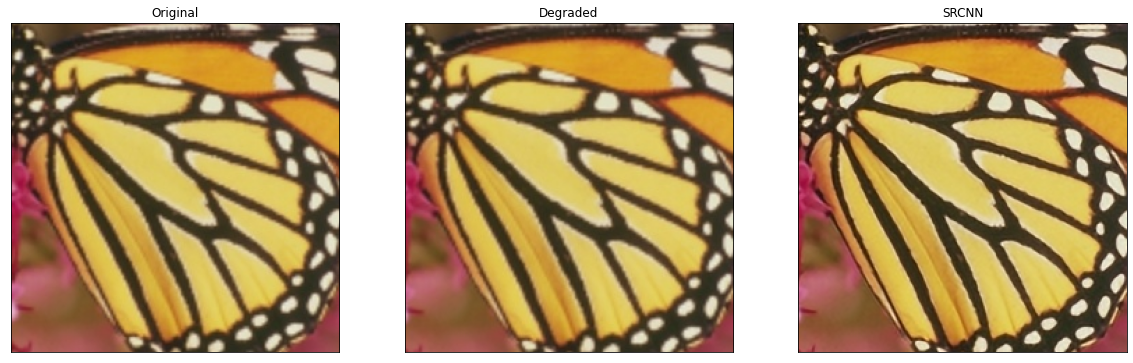

In [22]:
import matplotlib.pyplot as plt 
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original')
axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
axs[1].set_title('Degraded')
axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
axs[2].set_title('SRCNN')

# remove the x and y ticks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])